# kaggle_RFM

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import psycopg2

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

In [153]:
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [154]:
from matplotlib.ticker import ScalarFormatter
import datetime

In [155]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [156]:
# 데이터베이스 연결 설정
conn = psycopg2.connect(database="postgres", user="postgres", password="postgres123", host="postgres.c4brhfvhrm5g.ap-northeast-2.rds.amazonaws.com", port=5432)

In [157]:
# 빈 데이터 프레임 만들기
df_order = pd.DataFrame()
df_order_items = pd.DataFrame()
df_payments = pd.DataFrame()
df_products = pd.DataFrame()
df_customers = pd.DataFrame()
df_sellers = pd.DataFrame()
df_closed_deals = pd.DataFrame()
df_mql = pd.DataFrame()
df_geoloc = pd.DataFrame()
df_reviews = pd.DataFrame()

# DB에서 데이터를 가져와 데이터프레임으로 만들기
def make_df(df, db_table):
    cur = conn.cursor()
    query = 'SELECT * FROM ' + db_table
    cur.execute(query)
    temp = cur.fetchall()
    df = pd.DataFrame(temp, columns=[desc[0] for desc in cur.description])
    cur.close()
    return df

df_order = make_df(df_order, '"order"')
df_order_items = make_df(df_order_items, 'order_items')
df_payments = make_df(df_payments, 'payments')
df_products = make_df(df_products, 'products')
df_customers = make_df(df_customers, 'customers')
df_sellers = make_df(df_sellers, 'sellers')
df_closed_deals = make_df(df_closed_deals, 'closed_deals')
df_mql = make_df(df_mql, 'mql')
df_geoloc = make_df(df_geoloc, 'geoloc')
df_reviews = make_df(df_reviews, 'reviews')

In [158]:
# order_status = ["delivered", "shipped", "invoiced", "processing"] 

#  "canceled", "unavailable", "created", "approved" 

# merge list

In [ ]:
# df_merged = df_order.merge(df_payments, on='order_id', how='left').merge(df_customers, on='customer_id', how='left')
# # 주문 상태 필터링
# df_filtered = df_merged[~df_merged['order_status'].isin(["canceled", "unavailable", "created", "approved" ])]
# rfm_customer = pd.merge(df_rfm, df_customers, on='customer_unique_id', how='left')
# rfm_order = pd.merge(df_rfm, df_order, left_on='customer_unique_id', right_on='customer_id', how='left')
# rfm_order_items = pd.merge(rfm_order, df_order_items, on='order_id', how='left')
# rfm_category = pd.merge(rfm_order_items, df_products, on='product_id', how='left')
# rfm_payment = pd.merge(rfm_order, df_payments, on='order_id', how='left')
# merged_payments = pd.merge(df_rfm, df_payments, left_on='customer_unique_id', right_on='order_id', how='inner')
# # rfm_df와 rfm_customer 병합
# merged_rfm = pd.merge(df_filtered, df_rfm[['customer_unique_id', 'class']], on='customer_unique_id', how='left')
# merged_rfm = pd.merge(df_rfm, customer_orders, on='customer_unique_id', how='left')
# df_revenue = df_filtered.merge(df_payments, on='order_id', how='left').groupby('order_purchase_month')['payment_value'].sum()

In [215]:
merged_rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class,order_count
0,42863,334,1,13664.08,2,1,5,2,63.120883,3,1
1,65587,515,2,7571.63,1,2,5,1,72.624458,1,2
2,77873,46,1,7274.88,5,1,5,1,83.652539,1,1
3,47299,563,1,6929.31,1,1,5,3,56.276997,4,1
4,15289,35,1,6922.21,5,1,5,0,83.652539,1,1


In [218]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,93586,1,credit_card,8,99.33
1,2955,1,credit_card,1,24.39
2,82474,1,credit_card,1,65.71
3,55775,1,credit_card,8,107.78
4,4054,1,credit_card,2,128.45


In [211]:
rfm_order.order_status.value_counts()

order_status
delivered      92145
shipped         1062
unavailable      582
canceled         572
invoiced         301
processing       295
created            4
approved           2
Name: count, dtype: int64

## rfm세분화

In [159]:
# 2018년 8월까지의 데이터만 사용하기
end_date = '2018-08-31'
df_order = df_order[df_order['order_purchase_timestamp'] <= end_date]

In [160]:
# merged df_order, df_payments merged
df_merged = df_order.merge(df_payments, on='order_id', how='left').merge(df_customers, on='customer_id', how='left')

In [222]:
# 주문 상태 필터링
df_filtered = df_merged[~df_merged['order_status'].isin(["canceled", "unavailable", "created", "approved" ])]

In [163]:
# RFM 계산
df_rfm = df_filtered.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': 'nunique',
    'payment_value': 'sum'
}).reset_index()

# 칼럼 이름
df_rfm.columns = ['customer_unique_id', 'R', 'F', 'M']

# Monetary 기준 내림차순
df_rfm = df_rfm.sort_values(by='M', ascending=False)

df_rfm

,customer_unique_id,R,F,M
42385,42863,2017-09-29 15:24:52,1,13664.08
64845,65587,2017-04-01 15:58:41,2,7571.63
76985,77873,2018-07-15 14:49:44,1,7274.88
46758,47299,2017-02-12 20:37:36,1,6929.31
15116,15289,2018-07-25 18:10:17,1,6922.21
...,...,...,...,...
42656,43137,2017-10-29 20:28:51,1,11.63
46471,47007,2018-06-21 20:29:25,1,10.89
48569,49130,2017-09-13 19:13:20,1,10.07
63445,64170,2018-08-25 21:20:50,1,9.59


In [164]:
df_rfm.isnull().sum()

customer_unique_id    0
R                     0
F                     0
M                     0
dtype: int64

In [165]:
df_rfm['R'] = pd.to_datetime(df_rfm['R'])
last_date = df_rfm['R'].max() + pd.to_timedelta(1, 'D')

df_rfm['R'] = last_date - df_rfm['R']
df_rfm['R'] = df_rfm['R'].dt.days

display(df_rfm.info(), df_rfm.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 94984 entries, 42385 to 41322
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  94984 non-null  int64  
 1   R                   94984 non-null  int64  
 2   F                   94984 non-null  int64  
 3   M                   94984 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 3.6 MB


None

,customer_unique_id,R,F,M
42385,42863,334,1,13664.08
64845,65587,515,2,7571.63
76985,77873,46,1,7274.88
46758,47299,563,1,6929.31
15116,15289,35,1,6922.21


C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\2901410645.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\2901410645.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\2901410645.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




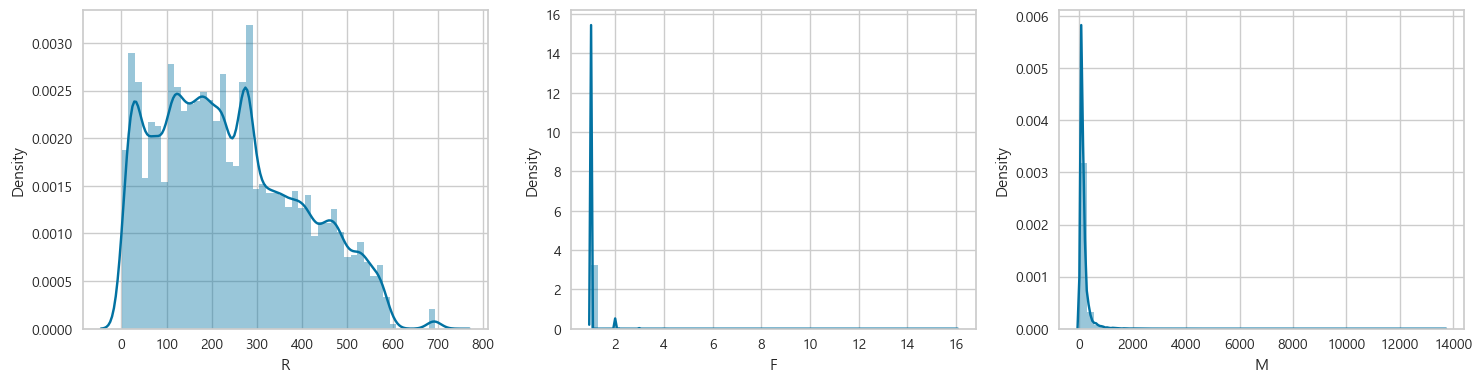

In [166]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes = axes.flatten()

for col, ax in zip(['R', 'F', 'M'], axes):
    sns.distplot(df_rfm[col], ax=ax, kde=True)
    
    # 지수 표기법 제거
    if col == 'R':
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()


In [167]:
percentile = [0.25, 0.5, 0.75, 0.9, 0.99]
df_rfm.R.describe(percentile)

count    94984.000000
mean       238.805157
std        152.995785
min          1.000000
25%        115.000000
50%        220.000000
75%        348.000000
90%        467.000000
99%        576.000000
max        724.000000
Name: R, dtype: float64

In [168]:
rfm_data.F.describe(percentile)

count    94984.000000
mean         1.033858
std          0.210810
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
90%          1.000000
99%          2.000000
max         16.000000
Name: F, dtype: float64

In [169]:
rfm_data.M.describe(percentile)

count    94984.000000
mean       165.693252
std        226.746987
min          0.000000
25%         63.100000
50%        107.900000
75%        182.942500
90%        318.970000
99%       1098.684600
max      13664.080000
Name: M, dtype: float64

# RFM 점수부여

In [170]:
df_rfm['R_score'] = pd.qcut(df_rfm['R'], 5, labels = [5, 4, 3, 2, 1])\
                      .astype(str)

df_rfm['F_score'] = df_rfm['F'].apply(lambda x : '1' if x == 1 else '2')

df_rfm['M_score'] = pd.qcut(df_rfm['M'], 5, labels = [1, 2, 3, 4, 5])\
                      .astype(str)

In [171]:
print(
        df_rfm['R_score'].value_counts(normalize=True)\
                           .sort_index(), '\n\n',
        df_rfm['F_score'].value_counts(normalize=True)\
                           .sort_index(),'\n\n',
        df_rfm['M_score'].value_counts(normalize=True)\
                           .sort_index()
       )

R_score
1    0.198907
2    0.198444
3    0.200202
4    0.201697
5    0.200750
Name: proportion, dtype: float64 

 F_score
1    0.969616
2    0.030384
Name: proportion, dtype: float64 

 M_score
1    0.200055
2    0.200002
3    0.199971
4    0.200002
5    0.199971
Name: proportion, dtype: float64


In [172]:
df_rfm.loc[(df_rfm.R_score <='2') & (df_rfm.M_score >='3')]

,customer_unique_id,R,F,M,R_score,F_score,M_score
42385,42863,334,1,13664.08,2,1,5
64845,65587,515,2,7571.63,1,2,5
46758,47299,563,1,6929.31,1,1,5
25504,25796,462,1,6726.66,1,1,5
13337,13482,279,1,6081.54,2,1,5
...,...,...,...,...,...,...,...
57829,58494,326,1,87.55,2,1,3
33907,34283,691,1,87.53,1,1,3
74672,75532,692,1,87.53,1,1,3
76200,77077,419,1,87.53,1,1,3


# 클러스터링

In [173]:
# 예측모델을 만들기 위함이 아니므로, 0~1사이를 반환하는 MinMax스케일링 실행

minmax = MinMaxScaler()

df_rfm_cluster = df_rfm[['R', 'F', 'M']]

df_rfm_scaled = minmax.fit_transform(df_rfm_cluster)
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=['R', 'F', 'M'])    
df_rfm_scaled.head()

,R,F,M
0,0.460581,0.000000,1.000000
1,0.710927,0.066667,0.554127
2,0.062241,0.000000,0.532409
3,0.777317,0.000000,0.507119
4,0.047026,0.000000,0.506599


c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.

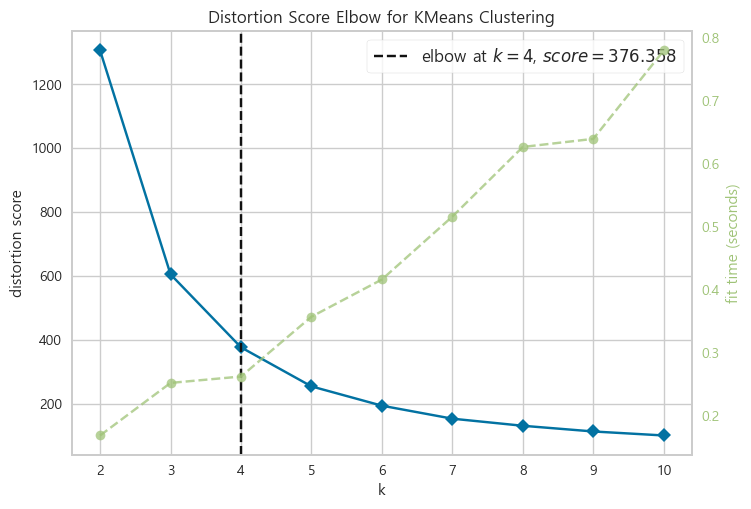

In [174]:
# kmeans클러스터링_ elbow방식으로 최적의 k구하기
# KElbowVisualizer 알고리즘을 통해 확인 가능하고, K=4일때가 최적임을 알 수 있습니다.

km = KMeans()
elbow = KElbowVisualizer(estimator = km, k = 10)
elbow.fit(df_rfm_scaled)
elbow.show()

plt.show()

In [175]:
# 총 4개의 클러스터

k = KMeans(n_clusters = 4, random_state = 42)
clusters = k.fit_predict(df_rfm_scaled)

df_rfm_scaled['cluster'] = clusters
df_rfm_scaled

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,R,F,M,cluster
0,0.460581,0.000000,1.000000,1
1,0.710927,0.066667,0.554127,2
2,0.062241,0.000000,0.532409,0
3,0.777317,0.000000,0.507119,2
4,0.047026,0.000000,0.506599,0
...,...,...,...,...
94979,0.419087,0.000000,0.000851,1
94980,0.094053,0.000000,0.000797,0
94981,0.482711,0.000000,0.000737,1
94982,0.004149,0.000000,0.000702,0


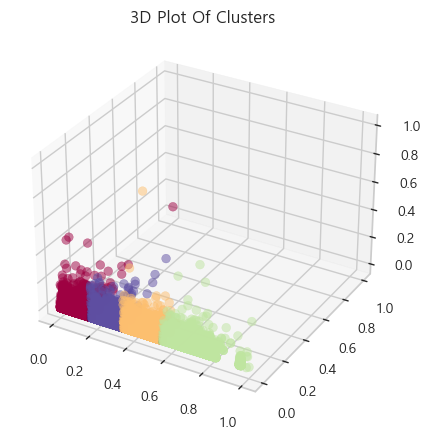

In [176]:
# 3차원 시각화로 클러스터링 상태를 확인합니다.

x = df_rfm_scaled['R']
y = df_rfm_scaled['F']
z = df_rfm_scaled['M']

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, s = 40, c = df_rfm_scaled['cluster'], marker = 'o', alpha = 0.5, cmap = 'Spectral')
ax.set_title("3D Plot Of Clusters")
plt.show()

In [177]:
df_rfm['cluster'] = df_rfm_scaled['cluster']
df_rfm['cluster'].value_counts().sort_index()

cluster
0    25771
1    24858
2    16818
3    27537
Name: count, dtype: int64

# R,F,M 가중치 계산

In [178]:
temp = df_rfm.pivot_table(index = 'cluster', values=['R', 'F', 'M'], aggfunc=['mean', 'std'])
temp

mean                               std                        
                F           M           R         F           M           R
cluster                                                                    
0        1.034186  166.512299  239.178456  0.205935  222.604774  153.014553
1        1.034838  164.626567  240.221579  0.208812  224.633318  153.421060
2        1.032227  165.592894  237.907302  0.199084  245.620157  152.827223
3        1.033627  165.944890  237.725533  0.223612  220.398647  152.692947

In [179]:
# Recency = w1

cv_r_0 = temp[('std', 'R')][0] / temp[('mean', 'R')][0]
cv_r_1 = temp[('std', 'R')][1] / temp[('mean', 'R')][1]
cv_r_2 = temp[('std', 'R')][2] / temp[('mean', 'R')][2]
cv_r_3 = temp[('std', 'R')][3] / temp[('mean', 'R')][3]

w_r = np.min([cv_r_0, cv_r_1, cv_r_2, cv_r_3]) / np.sum([cv_r_0, cv_r_1, cv_r_2, cv_r_3])
w_r

0.24917625694850162

In [180]:
# Frequency = w2

cv_f_0 = temp[('std', 'F')][0] / temp[('mean', 'F')][0]
cv_f_1 = temp[('std', 'F')][1] / temp[('mean', 'F')][1]
cv_f_2 = temp[('std', 'F')][2] / temp[('mean', 'F')][2]
cv_f_3 = temp[('std', 'F')][3] / temp[('mean', 'F')][3]

w_f = np.min([cv_f_0, cv_f_1, cv_f_2, cv_f_3]) / np.sum([cv_f_0, cv_f_1, cv_f_2, cv_f_3])
w_f

0.2380752373390671

In [181]:
# Monetary = w3

cv_m_0 = temp[('std', 'M')][0] / temp[('mean', 'M')][0]
cv_m_1 = temp[('std', 'M')][1] / temp[('mean', 'M')][1]
cv_m_2 = temp[('std', 'M')][2] / temp[('mean', 'M')][2]
cv_m_3 = temp[('std', 'M')][3] / temp[('mean', 'M')][3]

w_m = np.min([cv_m_0, cv_m_1, cv_m_2, cv_m_3]) / np.sum([cv_m_0, cv_m_1, cv_m_2, cv_m_3])
w_m

0.24092041468742173

In [182]:
# 모든 가중치의 합을 1로 만들도록 변환하여 최종적으로 각 R, F, M에 대한 가중치를 구하였습니다.

W_R = w_r / (w_r + w_f + w_m)
W_F = w_f / (w_r + w_f + w_m)
W_M = w_m / (w_r + w_f + w_m)

print(f'Weight of Recency  : {W_R}')
print(f'Weight of Frequency: {W_F}')
print(f'Weight of Monetary : {W_M}')
print(f'Total sum of weight: {np.sum([W_R, W_F, W_M])}')

Weight of Recency  : 0.3421942729145567
Weight of Frequency: 0.32694921955200545
Weight of Monetary : 0.3308565075334378
Total sum of weight: 1.0


# 고객별 RFM점수 산정

In [183]:
df_rfm['RFM_score'] = (df_rfm['R_score'].astype('int64') * W_R / 5 * 100 \
                        + df_rfm
                    ['F_score'].astype('int64') * W_F / 2 * 100 \
                        + df_rfm
                    ['M_score'].astype('int64') * W_M / 5 * 100)

df_rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score
42385,42863,334,1,13664.08,2,1,5,2,63.120883
64845,65587,515,2,7571.63,1,2,5,1,72.624458
76985,77873,46,1,7274.88,5,1,5,1,83.652539
46758,47299,563,1,6929.31,1,1,5,3,56.276997
15116,15289,35,1,6922.21,5,1,5,0,83.652539


# 고객별 RFM점수에 따른 고객 등급화

In [184]:
df_rfm.RFM_score.describe()

count    94984.000000
mean        57.273578
std         14.206781
min         29.808477
25%         49.659867
50%         56.730508
75%         69.964768
max        100.000000
Name: RFM_score, dtype: float64

In [185]:
df_rfm.pivot_table(index = 'RFM_score', values=['R', 'F', 'M'], aggfunc=['mean', 'count'])

mean                         count            
                   F           M           R     F     M     R
RFM_score                                                     
29.808477   1.000000   39.718249  477.231258  3935  3935  3935
36.425607   1.000000   71.086283  472.924143  3968  3968  3968
36.652362   1.000000   40.047400  317.004426  3615  3615  3615
43.042737   1.000000  109.320684  473.618736  3672  3672  3672
43.269492   1.000000   70.493088  318.975037  4006  4006  4006
43.496248   1.000000   39.533054  220.239230  3946  3946  3946
46.155938   2.125000   41.708750  539.000000     8     8     8
49.659867   1.000000  164.310238  474.071988  3320  3320  3320
49.886622   1.000000  108.666590  318.347623  3639  3639  3639
50.113378   1.000000   70.425828  221.929643  3667  3667  3667
50.340133   1.000000   39.853847  136.969139  3694  3694  3694
52.773068   2.076923   73.822051  482.743590    39    39    39
52.999823   2.000000   46.663333  341.000000     3     3     3
56.276997   1.000000  444.792852  479.276164  3545  3545  3545
56.503752   1.000000  165.376894  317.213919  3506  3506  3506
56.730508   1.000000  108.242665  222.915049  3708  3708  3708
56.957263   1.000000   70.460994  137.179452  3611  3611  3611
57.184018   1.000000   39.540235   45.279863  3784  3784  3784
59.390198   2.126761  110.307183  462.098592    71    71    71
59.616953   2.000000   73.973143  316.114286    35    35    35
59.843708   2.000000   44.930000  190.500000     2     2     2
63.120883   1.000000  454.566651  317.897297  3515  3515  3515
63.347638   1.000000  165.134148  222.162134  3787  3787  3787
63.574393   1.000000  108.306287  134.958016  3811  3811  3811
63.801149   1.000000   70.563841   43.794249  3582  3582  3582
66.007328   2.043860  168.722281  467.245614   114   114   114
66.234083   2.010638  114.526277  315.117021    94    94    94
66.460839   2.000000   74.674231  216.000000    26    26    26
66.687594   2.000000   46.547778  141.444444     9     9     9
69.964768   1.000000  411.457003  222.160790  3290  3290  3290
70.191523   1.000000  166.057524  137.494976  3881  3881  3881
70.418279   1.000000  108.638942   45.948977  3763  3763  3763
72.624458   2.081448  432.054751  462.619910   221   221   221
72.851213   2.062069  169.299655  318.434483   145   145   145
73.077969   2.023810  110.264524  223.869048    84    84    84
73.304724   2.000000   74.153871  131.645161    31    31    31
73.531479   2.000000   42.865000   56.500000     6     6     6
76.808654   1.000000  452.058500  137.066292  3560  3560  3560
77.035409   1.000000  165.788262   46.565125  3785  3785  3785
79.468344   2.116838  468.722577  321.408935   291   291   291
79.695099   2.037975  172.739051  216.626582   158   158   158
79.921854   2.013699  110.659589  137.150685    73    73    73
80.148610   2.000000   73.272813   38.906250    32    32    32
83.652539   1.000000  451.570761   47.699259  3508  3508  3508
86.312229   2.132184  432.954052  220.252874   348   348   348
86.538984   2.072848  170.704570  135.635762   151   151   151
86.765740   2.050633  113.081646   49.113924    79    79    79
93.156115   2.210682  460.321751  135.967359   337   337   337
93.382870   2.033333  168.892333   47.133333   150   150   150
100.000000  2.271768  453.887968   47.403694   379   379   379

In [186]:
df_rfm['class'] = pd.qcut(df_rfm.RFM_score, 5, labels = [5, 4, 3, 2, 1]).astype(str)
df_rfm.head(10)

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class
42385,42863,334,1,13664.08,2,1,5,2,63.120883,3
64845,65587,515,2,7571.63,1,2,5,1,72.624458,1
76985,77873,46,1,7274.88,5,1,5,1,83.652539,1
46758,47299,563,1,6929.31,1,1,5,3,56.276997,4
15116,15289,35,1,6922.21,5,1,5,0,83.652539,1
25504,25796,462,1,6726.66,1,1,5,3,56.276997,4
13337,13482,279,1,6081.54,2,1,5,1,63.120883,3
52618,53226,498,1,4764.34,1,1,5,1,56.276997,4
71200,72019,69,1,4681.78,5,1,5,3,83.652539,1
27142,27450,22,4,4655.91,5,2,5,2,100.000000,1


# 세그먼트 별 분석

## 주별 고객 수

In [187]:
rfm_customer

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,42863,339,1,13664.08,2,1,5,0,63.216250,3,47718,20080,rio de janeiro,RJ
1,65587,520,2,7571.63,1,2,5,1,72.755390,1,69495,28970,araruama,RJ
2,65587,520,2,7571.63,1,2,5,1,72.755390,1,62835,28970,araruama,RJ
3,77873,50,1,7274.88,5,1,5,1,83.649707,1,86330,29102,vila velha,ES
4,47299,568,1,6929.31,1,1,5,2,56.405097,4,25556,79042,campo grande,MS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98315,43137,309,1,11.63,2,1,1,0,36.621328,5,39258,3367,sao paulo,SP
98316,47007,74,1,10.89,5,1,1,2,57.054786,3,94475,4046,sao paulo,SP
98317,49130,355,1,10.07,2,1,1,1,36.621328,5,5652,4814,sao paulo,SP
98318,64170,9,1,9.59,5,1,1,3,57.054786,3,40616,13140,paulinia,SP


In [188]:
rfm_customer = pd.merge(df_rfm, df_customers, on='customer_unique_id', how='left')
rfm_state = rfm_customer.groupby(['class', 'customer_state']).size().reset_index(name='Counts')
rfm_state

,class,customer_state,Counts
0,1,AC,21
1,1,AL,85
2,1,AM,31
3,1,AP,18
4,1,BA,702
...,...,...,...
130,5,RS,1165
131,5,SC,766
132,5,SE,68
133,5,SP,8149


In [189]:
colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

fig = px.bar(rfm_state, 
             x='customer_state', 
             y='Counts', 
             color='class',
             title='주별 고객 수',
             labels={'customer_state': '주(State)', 'Counts': '고객 수'},
             color_discrete_sequence=colors)
fig.show()

## 소비 카테고리 TOP5

In [190]:
rfm_order = pd.merge(df_rfm, df_order, left_on='customer_unique_id', right_on='customer_id', how='left')
rfm_order_items = pd.merge(rfm_order, df_order_items, on='order_id', how='left')
rfm_category = pd.merge(rfm_order_items, df_products, on='product_id', how='left')

rfm_category= rfm_category.groupby(['class', 'product_category_name']).size().reset_index(name='Counts')
top5_categories = rfm_category.groupby('class').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)
top5_categories

,class,product_category_name,Counts
0,1,bed_bath_table,1875
1,1,health_beauty,1679
2,1,sports_leisure,1509
3,1,furniture_decor,1499
4,1,computers_accessories,1363
5,2,bed_bath_table,2140
6,2,health_beauty,1786
7,2,sports_leisure,1602
8,2,furniture_decor,1531
9,2,computers_accessories,1431


In [191]:
colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

fig = px.bar(top5_categories, 
             x='product_category_name', 
             y='Counts', 
             color='class',
             title='세그먼트 별 많이 지출한 TOP5 카테고리',
             labels={'product_category_name': 'Product Category', 'Counts': '구매 수(count)'},
             color_discrete_sequence=colors)
fig.show()

## rfm 등급별 결제수단

In [192]:
rfm_payment = pd.merge(rfm_order, df_payments, on='order_id', how='left')
rfm_payment = rfm_payment.groupby(['class', 'payment_type']).size().reset_index(name='Counts')
rfm_payment


,class,payment_type,Counts
0,1,boleto,3400
1,1,credit_card,13238
2,1,debit_card,241
3,1,not_defined,1
4,1,voucher,997
5,2,boleto,3751
6,2,credit_card,14351
7,2,debit_card,270
8,2,voucher,1016
9,3,boleto,3588


In [193]:
colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

fig = px.bar(rfm_payment, 
             x='payment_type', 
             y='Counts', 
             color='class',
             title='세그먼트 별 결제 방식',
             labels={'payment_type': 'Payment Type', 'Counts': '사용 수(count)'},
             color_discrete_sequence=colors)
fig.show()

## 주문상태

In [194]:
rfm_order = pd.merge(df_rfm, df_order, left_on='customer_unique_id', right_on='customer_id', how='inner')

order_status_counts = rfm_order.groupby(['class', 'order_status']).size().reset_index(name='Counts')


colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']
fig = px.bar(order_status_counts, 
             x='order_status', 
             y='Counts', 
             color='class',
             title='세그먼트 별 주문상태',
             labels={'order_status': '주문 상태', 'Counts': '주문 수'},
             color_discrete_sequence=colors)
fig.show()

In [195]:
order_status_counts

,class,order_status,Counts
0,1,canceled,108
1,1,delivered,16609
2,1,invoiced,47
3,1,processing,51
4,1,shipped,181
5,1,unavailable,103
6,2,canceled,115
7,2,created,1
8,2,delivered,18037
9,2,invoiced,54


## 지출액의 평균과 총합

In [196]:
merged_payments

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,42863,339,1,13664.08,2,1,5,0,63.216250,3,42863,1,credit_card,3,153.48
1,65587,520,2,7571.63,1,2,5,1,72.755390,1,65587,1,credit_card,1,53.90
2,77873,50,1,7274.88,5,1,5,1,83.649707,1,77873,1,credit_card,2,162.06
3,47299,568,1,6929.31,1,1,5,2,56.405097,4,47299,1,boleto,1,74.40
4,15289,40,1,6922.21,5,1,5,1,83.649707,1,15289,1,credit_card,1,66.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99171,43137,309,1,11.63,2,1,1,0,36.621328,5,43137,1,boleto,1,169.87
99172,47007,74,1,10.89,5,1,1,2,57.054786,3,47007,1,boleto,1,130.75
99173,49130,355,1,10.07,2,1,1,1,36.621328,5,49130,1,boleto,1,109.69
99174,64170,9,1,9.59,5,1,1,3,57.054786,3,64170,1,credit_card,1,54.80


In [197]:
merged_payments = pd.merge(df_rfm, df_payments, left_on='customer_unique_id', right_on='order_id', how='inner')

# sum과 mean 함께 계산
avg_payment = merged_payments.groupby('class').agg({
    'M': ['sum', 'mean']
}).reset_index()

# 열 이름 변경
avg_payment.columns = ['class', 'total_monetary', 'average_monetary']

In [198]:
# 시각화
fig = go.Figure()

# 총 결제 금액 바 그래프 추가
fig.add_trace(go.Bar(
    x=avg_payment['class'],
    y=avg_payment['total_monetary'],
    name='총 지출액',
    marker_color='#A0BFE0',
    yaxis='y1'
))

# 평균 결제 금액 꺾은선 그래프 추가
fig.add_trace(go.Scatter(
    x=avg_payment['class'],
    y=avg_payment['average_monetary'],
    name='평균 지출액',
    mode='lines+markers',
    line=dict(color='#4A55A2'),
    marker=dict(color='#3C4482', size=10),
    yaxis='y2'
))

# 레이아웃 설정
fig.update_layout(
    title='세그먼트 별 Monetray의 총 금액(sum)과 평균 금액(Average)',
    xaxis_title='Segment',
    yaxis=dict(title='총 지출액', anchor="x", side="left", position=0.00),
    yaxis2=dict(title='평균 지출액', anchor="x", overlaying="y", side="right")
)

fig.show()

## 평균 배송 시간

In [199]:
rfm_customer.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,42863,334,1,13664.08,2,1,5,2,63.120883,3,47718,20080,rio de janeiro,RJ
1,65587,515,2,7571.63,1,2,5,1,72.624458,1,69495,28970,araruama,RJ
2,65587,515,2,7571.63,1,2,5,1,72.624458,1,62835,28970,araruama,RJ
3,77873,46,1,7274.88,5,1,5,1,83.652539,1,86330,29102,vila velha,ES
4,47299,563,1,6929.31,1,1,5,3,56.276997,4,25556,79042,campo grande,MS


In [200]:
df_rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class
42385,42863,334,1,13664.08,2,1,5,2,63.120883,3
64845,65587,515,2,7571.63,1,2,5,1,72.624458,1
76985,77873,46,1,7274.88,5,1,5,1,83.652539,1
46758,47299,563,1,6929.31,1,1,5,3,56.276997,4
15116,15289,35,1,6922.21,5,1,5,0,83.652539,1


In [201]:
df_filtered['order_purchase_timestamp'] = pd.to_datetime(df_filtered['order_purchase_timestamp'])
df_filtered['order_delivered_customer_date'] = pd.to_datetime(df_filtered['order_delivered_customer_date'])
df_filtered['Delivery_Time'] = (df_filtered['order_delivered_customer_date'] - df_filtered['order_purchase_timestamp']).dt.days

C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\3835209915.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\3835209915.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lovel\AppData\Local\Temp\ipykernel_21148\3835209915.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [202]:
# rfm_df와 rfm_customer 병합
merged_rfm = pd.merge(df_filtered, df_rfm[['customer_unique_id', 'class']], on='customer_unique_id', how='left')

In [203]:
merged_rfm.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Delivery_Time,class
0,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12,39184,3149,sao paulo,SP,8.0,3
1,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00,39184,3149,sao paulo,SP,8.0,3
2,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59,39184,3149,sao paulo,SP,8.0,3
3,83165,13301,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46,71798,47813,barreiras,BA,13.0,1
4,66104,44559,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12,24317,75265,vianopolis,GO,9.0,1


In [204]:
# 각 클래스별로 평균 배송 시간 계산
avg_delivery_time = merged_rfm.groupby('class')['Delivery_Time'].mean().reset_index()

# 시각화
avg_delivery_time['colors'] = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

color_map = dict(zip(avg_delivery_time['class'], avg_delivery_time['colors']))

fig = px.bar(avg_delivery_time, 
             x='class', 
             y='Delivery_Time', 
             color='class',
             title='세그먼트 별 평균 배송 시간(Days)',
             labels={'class': 'Segment', 'Delivery_Time': '평균 배송 시간 (Days)'},
             color_discrete_map=color_map)
fig.show()

## 재구매율

In [205]:
customer_orders

,customer_unique_id,order_count
0,0,1
1,1,1
2,2,1
3,3,2
4,4,2
...,...,...
94979,96091,1
94980,96092,1
94981,96093,1
94982,96094,1


In [206]:
# 고객별 주문 횟수 계산
customer_orders = merged_rfm.groupby(['customer_unique_id']).size().reset_index(name='order_count')

# df__rfm와 customer_orders 병합
merged_rfm = pd.merge(df_rfm, customer_orders, on='customer_unique_id', how='left')

# 각 세그먼트별 재구매한 고객의 수 계산
repurchase_counts = merged_rfm[merged_rfm['order_count'] > 1].groupby('class').size().reset_index(name='repurchase_count')

# 각 세그먼트별 전체 고객의 수 계산
total_counts = merged_rfm.groupby('class').size().reset_index(name='total_count')

# 두 데이터프레임 병합
repurchase_rate_df = pd.merge(total_counts, repurchase_counts, on='class', how='left')

# 재구매율 계산
repurchase_rate_df['repurchase_rate'] = repurchase_rate_df['repurchase_count'] / repurchase_rate_df['total_count'] * 100

repurchase_rate_df[['class', 'repurchase_rate']]


,class,repurchase_rate
0,1,16.659844
1,2,3.764655
2,3,3.471918
3,4,3.311834
4,5,3.552824


In [207]:
repurchase_rate_df['colors'] = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

color_map = dict(zip(repurchase_rate_df['class'], repurchase_rate_df['colors']))

fig = px.bar(repurchase_rate_df, 
             x='class', 
             y='repurchase_rate',
             color='class',
             title='세그먼트 별 재구매율(%)',
             labels={'class': 'Segment', 'repurchase_rate': '재구매율 (%)'},
             color_discrete_map=color_map)


#fig.update_layout(showlegend=False)  # 범례가 필요없을 경우
fig.update_yaxes(tickformat=".2f")   # Y축 값을 소수점 두 자리로 제한

fig.show()

# 세그먼트별 총 수익과 월별 변화

In [229]:
# df_rfm과 df_filtered를 customer_id를 기준으로 조인
merged_data = df_filtered.merge(df_rfm, left_on='customer_id', right_index=True)

# 세그먼트와 월별로 매출을 합산
segment_monthly_revenue = merged_data.merge(df_payments, on='order_id').groupby(['class', 'order_purchase_month'])['payment_value_x'].sum().reset_index()

# 세그먼트별 총 매출
total_revenue_by_segment = segment_monthly_revenue.groupby('class')['payment_value_x'].sum()


In [247]:
# df_rfm과 df_filtered를 customer_id를 기준으로 조인
merged_data = df_filtered.merge(df_rfm, left_on='customer_id', right_index=True)

# 세그먼트와 월별로 매출을 합산
segment_monthly_revenue = merged_data.merge(df_payments, on='order_id').groupby(['class', 'order_purchase_month'])['payment_value_x'].sum().reset_index()

colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']
# Data preparation
fig = go.Figure()

for idx, segment in enumerate(segment_monthly_revenue['class'].unique()):
    monthly_data = segment_monthly_revenue[segment_monthly_revenue['class'] == segment]
    fig.add_trace(go.Scatter(x=monthly_data['order_purchase_month'].astype(str),
                             y=monthly_data['payment_value_x'],
                             mode='lines+markers',
                             name=f"Segment {segment}",
                             line=dict(color=colors[idx])))

# Layout settings
fig.update_layout(title="세그먼트별 월별 매출 변화",
                  xaxis_title="월",
                  yaxis_title="매출",
                  xaxis=dict(tickangle=45))

fig.show()


## 세그먼트별 평균 주문 금액(AOV)

In [244]:
# 세그먼트 정보를 주문 데이터와 병합
df_order_with_segment = df_filtered.merge(df_rfm, left_on='customer_unique_id', right_index=True)

# 세그먼트별 AOV 계산
df_segment_aov = df_order_with_segment.merge(df_payments, on='order_id').groupby('class').agg({'payment_value_x':'mean'})#.sort_values(by='payment_value_x', ascending=False)


fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_segment_aov.index, 
    y=df_segment_aov['payment_value_x'], 
    marker_color=colors
))

fig.update_layout(
    title='세그먼트별 평균 주문 금액(AOV)',
    xaxis_title="Segment",
    yaxis_title="AOV",
    barmode='group'
)

fig.show()


## 세그먼트별 카테고리 aov

In [239]:
df_category_segment_aov = df_order_with_segment.merge(df_order_items, on='order_id').merge(df_products, on='product_id').groupby(['class', 'product_category_name']).agg({'price':'mean'}).reset_index()

colors = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']
segments = df_category_segment_aov['class'].unique()

fig = go.Figure()

for idx, segment in enumerate(segments):
    temp = df_category_segment_aov[df_category_segment_aov['class'] == segment].sort_values(by='price', ascending=False).head(10)
    fig.add_trace(go.Bar(
        x=temp['product_category_name'], 
        y=temp['price'], 
        name=f"Segment {segment}", 
        marker_color=colors[idx]
    ))

fig.update_layout(
    title='세그먼트별 카테고리별 평균 주문 금액(AOV) TOP 10',
    xaxis_title="Product Category",
    yaxis_title="AOV",
    barmode='group'
)

fig.show()


## 세그먼트별 결제 방법AOV

In [243]:
df_payment_segment_aov = df_order_with_segment.merge(df_payments, on='order_id').groupby(['class', 'payment_type_x']).agg({'payment_value_x':'mean'}).reset_index()

fig = go.Figure()

for idx, segment in enumerate(segments):
    temp = df_payment_segment_aov[df_payment_segment_aov['class'] == segment]
    fig.add_trace(go.Bar(
        x=temp['payment_type_x'], 
        y=temp['payment_value_x'], 
        name=f"Segment {segment}", 
        marker_color=colors[idx]
    ))

fig.update_layout(
    title='세그먼트별 결제방법별 평균 주문 금액(AOV)',
    xaxis_title="Payment Type",
    yaxis_title="AOV",
    barmode='group'
)

fig.show()

# 세그먼트별 평균 주문 취소율

In [258]:
# 1. 각 고객별 주문 취소율 계산
customer_orders = df_order.groupby('customer_id').size().reset_index(name='total_orders')
customer_cancelled_orders = df_order[df_order['order_status'] == 'canceled'].groupby('customer_id').size().reset_index(name='cancelled_orders')
customer_orders = customer_orders.merge(customer_cancelled_orders, on='customer_id', how='left').fillna(0)
customer_orders['cancel_rate'] = (customer_orders['cancelled_orders'] / customer_orders['total_orders']) * 100

# 2. df_rfm과 결합
df_rfm_extended = df_rfm.merge(df_customers[['customer_id', 'customer_unique_id']], on='customer_unique_id', how='left')
df_rfm_extended = df_rfm_extended.merge(customer_orders[['customer_id', 'cancel_rate']], on='customer_id', how='left').fillna(0)

# 3. 세그먼트별 평균 주문 취소율 계산
segment_cancel_rate = df_rfm_extended.groupby('class')['cancel_rate'].mean()

segment_cancel_rate

class
1    0.155466
2    0.079500
3    0.054451
4    0.027360
5    0.067648
Name: cancel_rate, dtype: float64

In [261]:
df_segment_cancel_rate = segment_cancel_rate.reset_index()

fig = px.bar(df_segment_cancel_rate, 
             x='class', 
             y='cancel_rate', 
             title='세그먼트별 평균 주문 취소율',
             labels={'class': '세그먼트', 'cancel_rate': '취소율(%)'},
             color='class', 
             color_discrete_sequence=['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8'])

fig.show()
